In [29]:
%matplotlib inline
import numpy as np
import pandas as pd
import requests
import math
import matplotlib.pyplot as plt
from time import sleep

## Get data

In [2]:
def trade_bucket(startDate='2015-01-01'):
    start = 0
    df = pd.DataFrame()
    data = True
    counter = 1
    
    while data:
        api_call_url = 'https://www.bitmex.com/api/v1/trade/bucketed?binSize=1d&partial=false&symbol=XBTUSD&count=1000&start=' + str(
                       start) +'&startTime=' + startDate
        r = requests.get(api_call_url)
        if r.status_code != 200:
            r.raise_for_status()
        data = r.json()
        if data:
            temp_df = pd.DataFrame(data)
            df = df.append(temp_df)
            start += 1000
        if counter < 30:
            counter += 1
        else:
            sleep(60)
            counter = 1
    df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True)
    df.set_index('timestamp', inplace=True)
    return df

In [3]:
trade_df = trade_bucket()

In [4]:
trade_df['percent_change'] = trade_df['open'].pct_change()
trade_df['log_percent_change'] = 100*np.log(1+trade_df['percent_change'])
trade_df['percent_change'] = 100*trade_df['percent_change']

data = trade_df['log_percent_change'].dropna()
data_train = data[:int(0.8*data.shape[0])]
data_test = data[int(0.8*data.shape[0]):]

## Statsmodel

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import norm

lookback = 30

# Fit the model
mod = SARIMAX(data, order=(30,0,0))
res = mod.fit()
res.summary()

c:\users\laide\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
c:\users\laide\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     log_percent_change   No. Observations:                 1600
Model:              SARIMAX(30, 0, 0)   Log Likelihood               -4488.498
Date:                Wed, 12 Feb 2020   AIC                           9038.996
Time:                        14:37:31   BIC                           9205.706
Sample:                    09-27-2015   HQIC                          9100.901
                         - 02-12-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0304      0.019     -1.586      0.113      -0.068       0.007
ar.L2          0.0180      0.021      0.867      0.386      -0.023       0.059
ar.L3          0.0295      0.021      1.410      0.158      -0.012       0.071
ar.L4         -0.0170      0.022     -0.783      0.434      -0.060       0.026
ar.L5          0.0354      0.019      1.846      0.065      -0.002       0.073
ar.L6          0.0250      0.020      1.236      0.217      -0.015       0.065
ar.L7          0.0002      0.023      0.009      0.993      -0.045       0.045
ar.L8         -0.0036      0.022     -0.160      0.873      -0.047       0.040
ar.L9         -0.0285      0.023     -1.258      0.208      -0.073       0.016
ar.L10         0.0593      0.024      2.488      0.013       0.013       0.106
ar.L11         0.0193      0.024      0.813      0.416      -0.027       0.066
ar.L12         0.0169      0.023      0.731      0.465      -0.028       0.062
ar.L13        -0.0262      0.023     -1.147      0.251      -0.071       0.019
ar.L14         0.0059      0.023      0.260      0.795      -0.038       0.050
ar.L15        -0.0145      0.022     -0.661      0.508      -0.058       0.029
ar.L16         0.0184      0.021      0.879      0.380      -0.023       0.060
ar.L17         0.0335      0.024      1.379      0.168      -0.014       0.081
ar.L18         0.0404      0.026      1.529      0.126      -0.011       0.092
ar.L19         0.0512      0.023      2.226      0.026       0.006       0.096
ar.L20         0.0229      0.024      0.960      0.337      -0.024       0.070
ar.L21        -0.0405      0.023     -1.769      0.077      -0.085       0.004
ar.L22         0.0026      0.025      0.105      0.917      -0.047       0.052
ar.L23        -0.0176      0.023     -0.771      0.440      -0.062       0.027
ar.L24        -0.0250      0.022     -1.126      0.260      -0.068       0.018
ar.L25         0.0043      0.024      0.182      0.855      -0.042       0.051
ar.L26        -0.0094      0.025     -0.378      0.705      -0.058       0.039
ar.L27         0.0192      0.023      0.824      0.410      -0.026       0.065
ar.L28        -0.0231      0.024     -0.948      0.343      -0.071       0.025
ar.L29        -0.0517      0.023     -2.260      0.024      -0.097      -0.007
ar.L30         0.0009      0.024      0.037      0.971      -0.046       0.048
sigma2        15.9991      0.357     44.775      0.000      15.299      16.699
===================================================================================
Ljung-Box (Q):                       16.50   Jarque-Bera (JB):              1176.68
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using t

In [33]:
# Choose a confidence interval
confidence = 0.5
bound = norm.interval(alpha=confidence,loc=0, scale=math.sqrt(res.params[-1]))

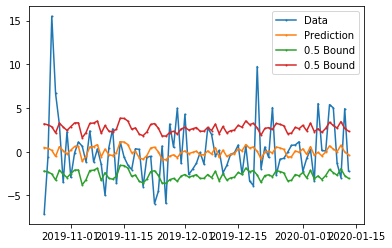

In [42]:
start = 1489
interval = 80

x_ax = data.index[start:start+interval+1]

y_t = res.predict(start=start, end=start+interval, dynamic=False).values
plt.plot_date(x_ax,data.values[start:start+interval+1],ms=1,ls='-')
plt.plot_date(x_ax,y_t,ms=1,ls='-')
plt.plot_date(x_ax,y_t+bound[0],ms=1,ls='-')
plt.plot_date(x_ax,y_t-bound[0],ms=1,ls='-')
plt.legend(['Data','Prediction',str(confidence)+' Bound',str(confidence)+' Bound'])